In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import numpy as np
import matplotlib
import math
import pprint
import seaborn as sns
from cityScraper import transformDataFrame
from sklearn.ensemble import RandomForestRegressor
from scipy.spatial.distance import cosine
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 5.5)
df = pd.read_csv('data/SF_data_private_3.csv',delimiter=',',index_col=0);
df = transformDataFrame(df)
df = df[df.price<300]
featureList = ['amen_'+str(i)for i in range(1,51)]
featureList += ['bin_acc_rating','bin_cancel_policy','bin_checkin_rating','bin_cleanliness_rating','bin_guest_sat','bin_host_other_rev_count','bin_instant_book','bin_is_apt','bin_loc_rating','bin_num_bathrooms','bin_num_beds','bin_person_cap','bin_pic_count','bin_review_count','bin_value_rating']
featureList = sorted(featureList)
dbList = featureList+['lat','lon','price','acc_rating','cancel_policy','checkin_rating','cleanliness_rating','guest_sat','host_other_rev_count','is_apt','instant_book','loc_rating','num_bathrooms','num_beds','person_cap','pic_count','review_count','value_rating']
dbList = sorted(dbList)

/Users/brian/Dropbox/Insight/PricePredictor/PricePredictor/cityScraper.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['num_bathrooms']=temp_df['num_bathrooms'].apply(lambda x:float(str(x).strip('+')))
/Users/brian/Dropbox/Insight/PricePredictor/PricePredictor/cityScraper.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['is_apt'] = df['prop_type'].apply(lambda x: x=='Apartment')
/Users/brian/Dropbox/Insight/PricePredictor/PricePredictor/cityScraper.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [45]:
df['dist_ferry_quant'] = pd.qcut(df['dist_ferry'],q=20)

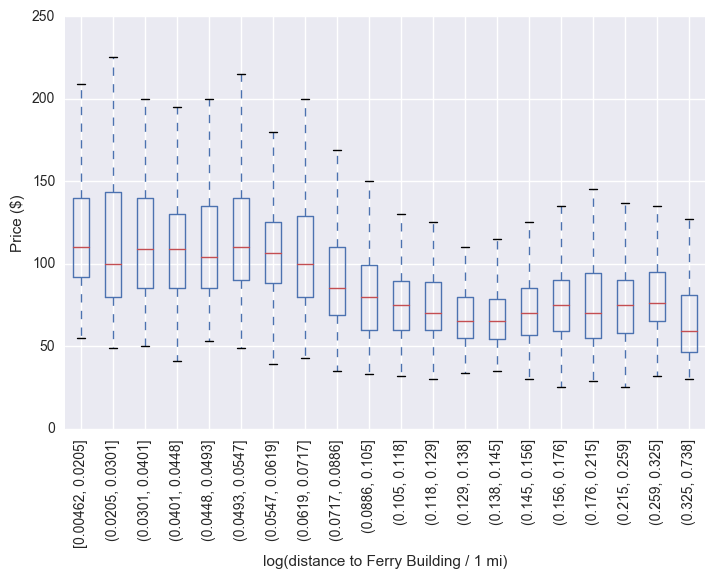

In [46]:
df.boxplot(column='price',by='dist_ferry_quant')
plt.xticks(rotation=90);
plt.title('');
plt.xlabel('log(distance to Ferry Building / 1 mi)')
plt.ylabel('Price ($)');
plt.ylim(0,250)
plt.suptitle('');

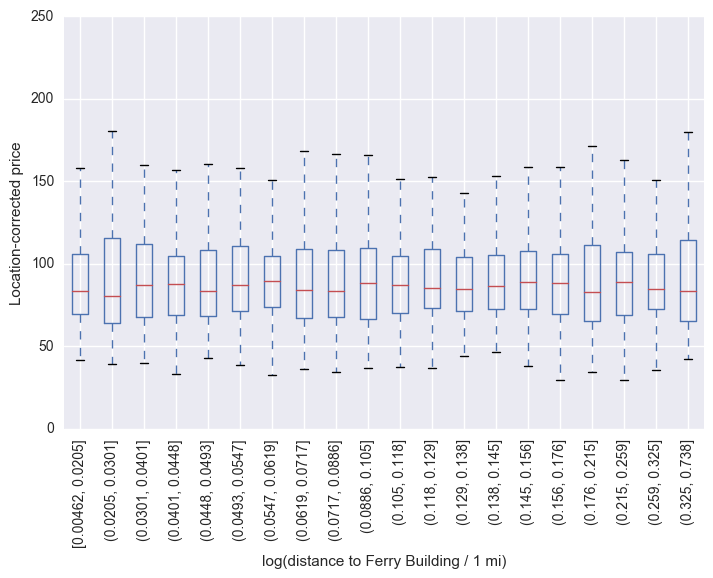

In [47]:
global_mean = df['price'].mean()
correct = lambda x : x*global_mean/x.mean()
df['corr_price']=df[['dist_ferry_quant','price']].groupby('dist_ferry_quant')['price'].transform(correct)
df.boxplot(column='corr_price',by='dist_ferry_quant')
plt.xticks(rotation=90);
plt.title('');
plt.xlabel('log(distance to Ferry Building / 1 mi)')
plt.ylabel('Location-corrected price')
plt.ylim(0,250);
plt.suptitle('');

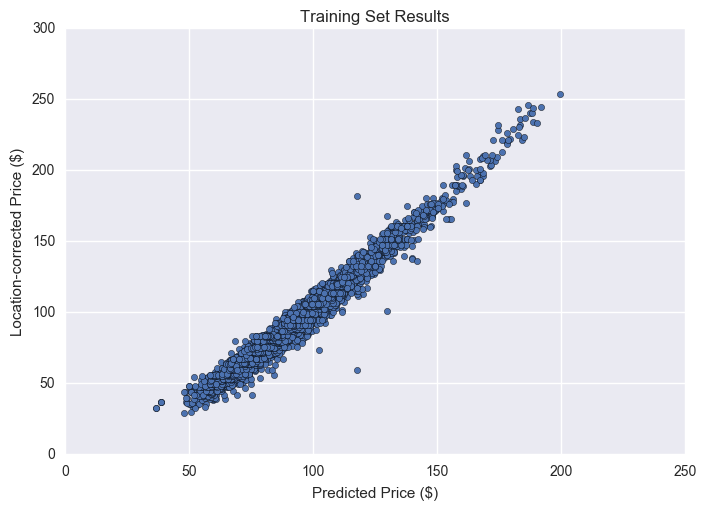

In [48]:
X = np.array(df[featureList])
Y = np.array(df['corr_price'].astype('float'))
forest=RandomForestRegressor(n_estimators=1000,max_features='log2',n_jobs=-1)
forest.fit(X,Y)
df['pred_price']=forest.predict(df[featureList])
df.plot(x='pred_price',y='corr_price',kind='scatter')
plt.title('Training Set Results')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Location-corrected Price ($)');

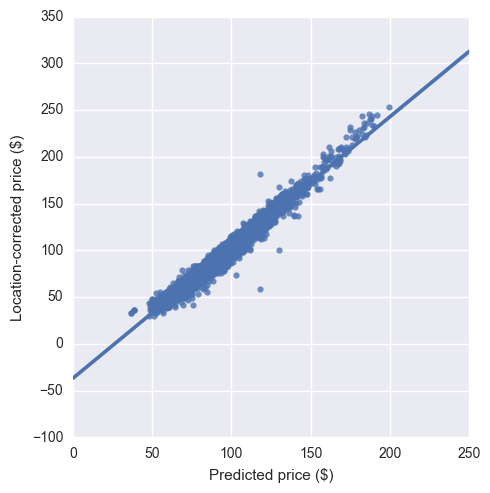

In [49]:
#df.plot(x='pred_price',y='corr_price',kind='scatter')
#plt.title('Training Set Results')
#plt.xlabel('Predicted Price ($)')
#plt.ylabel('Location-corrected Price ($)');
#x=df['pred_price'].values
#y=df['corr_price'].values
#np.poly1d(np.polyfit(x,y,1))
#np.polyfit(x,y,1)
#plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)));
sns.lmplot('pred_price','corr_price',data=df,scatter=True)
plt.xlabel('Predicted price ($)');
plt.ylabel('Location-corrected price ($)');

Feature ranking:
1. bin_loc_rating (0.031417)
2. bin_num_beds (0.028251)
3. bin_person_cap (0.027078)
4. amen_2 (0.026775)
5. bin_host_other_rev_count (0.025882)
6. bin_guest_sat (0.025481)
7. bin_cleanliness_rating (0.024705)
8. amen_9 (0.023946)
9. bin_cancel_policy (0.023867)
10. bin_review_count (0.023151)
11. bin_is_apt (0.022758)
12. amen_1 (0.022733)
13. amen_39 (0.021954)
14. amen_42 (0.021752)
15. amen_37 (0.021384)
16. amen_3 (0.021351)
17. amen_8 (0.021264)
18. amen_47 (0.020877)
19. amen_43 (0.020745)
20. amen_50 (0.020656)
21. amen_36 (0.020376)
22. amen_31 (0.020333)
23. bin_instant_book (0.019299)
24. bin_value_rating (0.019207)
25. amen_44 (0.019066)
26. amen_45 (0.018963)
27. amen_27 (0.018961)
28. amen_34 (0.018910)
29. amen_33 (0.018782)
30. amen_41 (0.018709)
31. amen_46 (0.018686)
32. amen_38 (0.017784)
33. amen_49 (0.017757)
34. amen_17 (0.017639)
35. amen_16 (0.017489)
36. amen_5 (0.017186)
37. bin_acc_rating (0.015914)
38. bin_checkin_rating (0.015626)
39. amen_

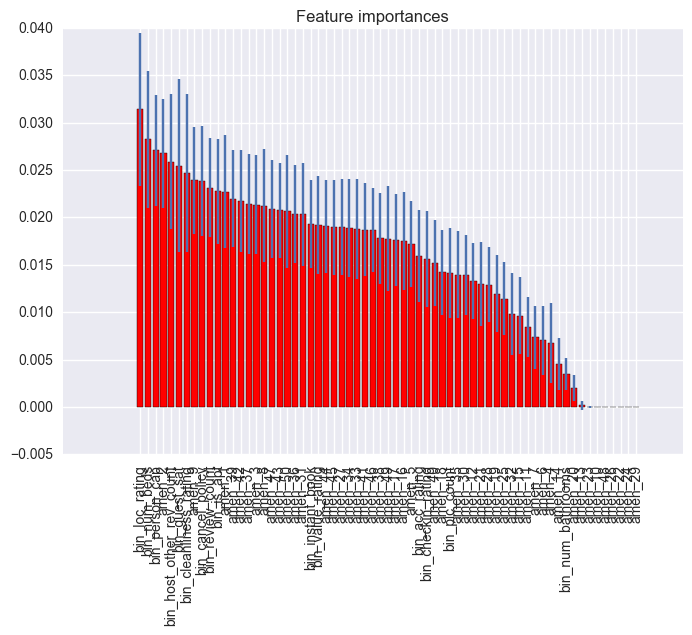

In [50]:
amen_name_dict = joblib.load('static/amen_name_dict.pkl')
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
importance_dict = {}
feature_list_amen_names = [feature for feature in featureList]
for f in range(X.shape[1]):
    print("%i. %s (%f)" % (f+1,featureList[indices[f]], importances[indices[f]]))
    importance_dict[featureList[indices[f]]] = importances[indices[f]]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
      color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), [featureList[i] for i in indices],rotation=90)
plt.show()

In [51]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

In [52]:
dbname = 'airbnb_db'
username = 'brian'
pswd = ''
engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))
print('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))
print(engine.url)

postgresql://brian:@localhost/airbnb_db
postgresql://brian:@localhost/airbnb_db


In [18]:
df[dbList].to_sql('binary_table', engine, if_exists='replace')

In [53]:
from sklearn.externals import joblib
joblib.dump(featureList,'static/featureList_binary_v1.pkl',compress=1);
joblib.dump(dbList,'static/dbList_binary_v1.pkl',compress=1);
joblib.dump(importance_dict,'static/importance_dict_v1.pkl',compress=1);

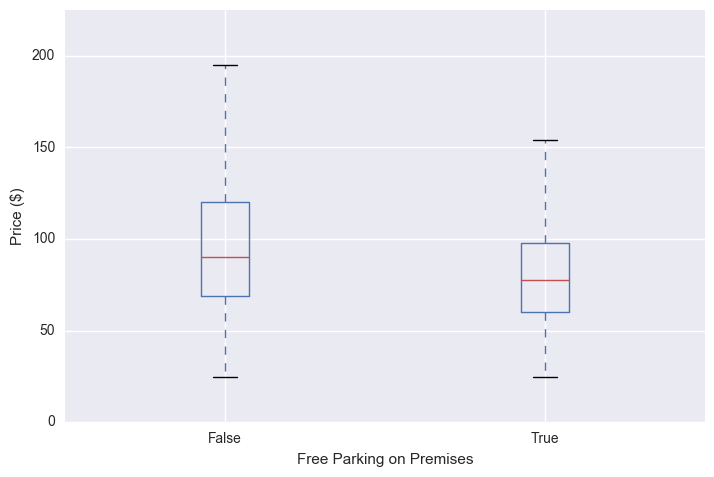

In [54]:
df.boxplot(column='price',by='amen_9');
plt.suptitle('');
plt.xlabel('Free Parking on Premises');
plt.ylabel('Price ($)');
plt.ylim(0,225);
plt.title('');

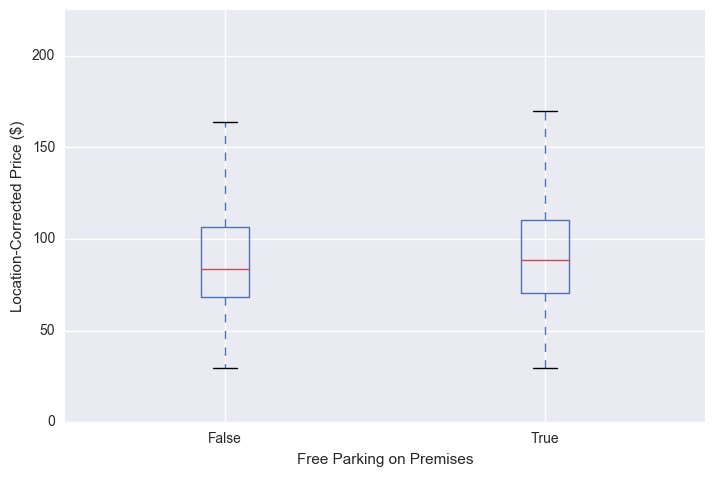

In [55]:
df.boxplot(column='corr_price',by='amen_9');
plt.suptitle('');
plt.xlabel('Free Parking on Premises');
plt.ylabel('Location-Corrected Price ($)');
plt.ylim(0,225);
plt.title('');